## IDE20K

# 1. Preparation

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

from exercise_code.data.segmentation_dataset import SegmentationData, label_img_to_rgb
from exercise_code.data.download_utils import download_dataset
from exercise_code.util import visualizer, save_model
from exercise_code.util.Util import checkSize, checkParams, test
from exercise_code.networks.segmentation_nn import SegmentationNN, DummySegmentationModel
from exercise_code.tests import test_seg_nn
#set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load and Visualize Data

In [3]:
# download_url = 'http://i2dl.vc.in.tum.de/static/data/segmentation_data.zip'
# i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
# data_root = os.path.join(i2dl_exercises_path, 'datasets','segmentation')


# download_dataset(
#     url=download_url,
#     data_dir=data_root,
#     dataset_zip_name='segmentation_data.zip',
#     force_download=False,
# )

train_data = SegmentationData(image_paths_file=f'segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file=f'segmentation_data/val.txt')
test_data = SegmentationData(image_paths_file=f'segmentation_data/test.txt')

If you want to implement data augmentation methods, make yourself familiar with the segmentation dataset and how we implemented the `SegmentationData` class in `exercise_code/data/segmentation_dataset.py`. Furthermore, you can check the original label description in `datasets/segmentation/segmentation_data/info.html`.

For now, let's look at a few samples of our training set:

Train size: 472
Validation size: 59
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


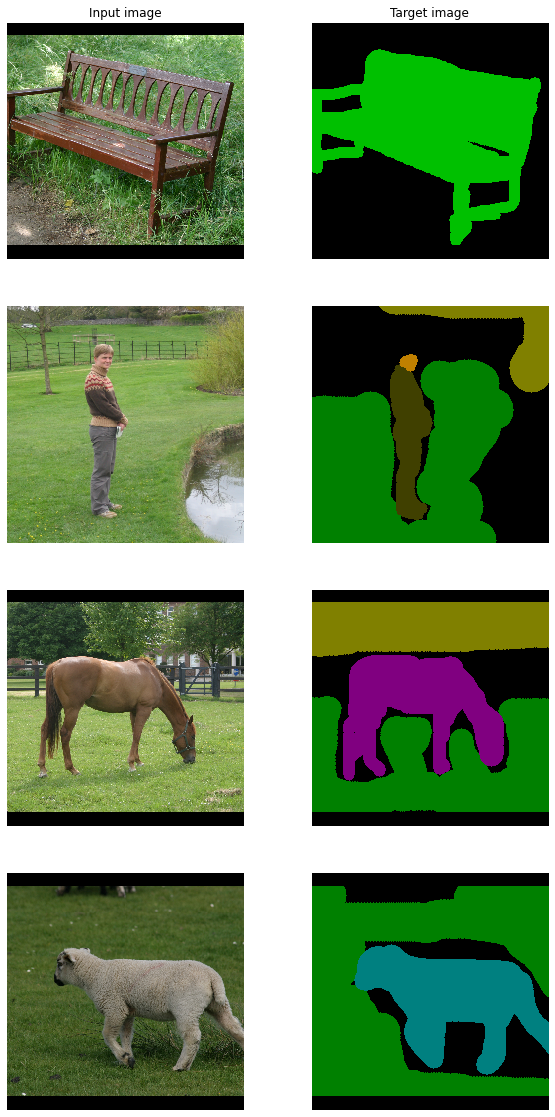

In [4]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 4
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

We can already see that the dataset is quite small in comparison to our previous datasets, e.g., for CIFAR10 we had ten thousands of images while we only have 276 training images in this case. In addition, the task is much more difficult than a "simple 10 class classification", as we have to assign a label to each pixel! What's more, the images are much bigger as we are now considering images of size 240x240 instead of 32x32. 

That means that you shouldn't expect our networks to perform very well, so don't be too disappointed.

# 2. Semantic Segmentation 

## Dummy Model

In `exercise_code/networks/segmentation_nn.py` we define a naive `DummySegmentationModel`, which always predicts the scores of segmentation labels of the first image. Let's try it on a few images and visualize the outputs using the `visualizer` we provide. The `visualizer` takes in the model and dataset, and visualizes the first four (Input, Target, Prediction) pairs. 

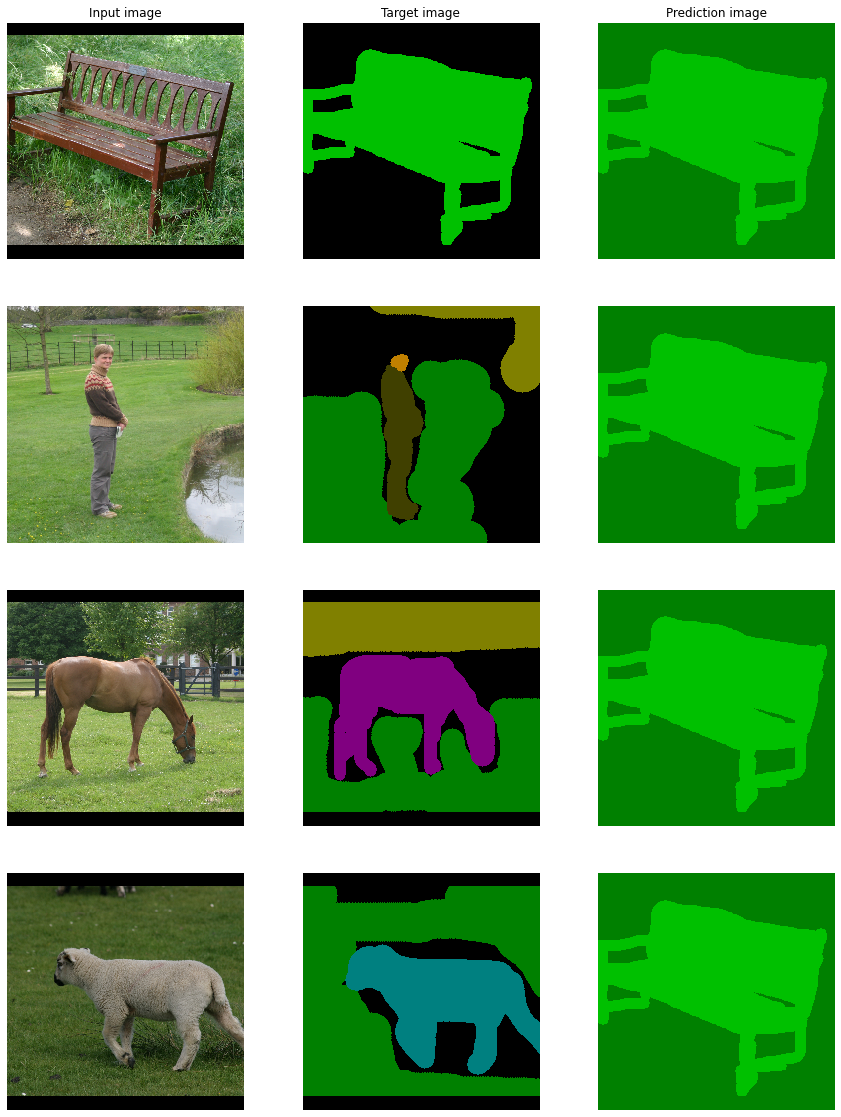

In [5]:
dummy_model = DummySegmentationModel(target_image=train_data[0][1])

# Visualization function
visualizer(dummy_model, train_data)

You can use the visualizer function in your training scenario to print out your model predictions on a regular basis.

## Loss and Metrics
The loss function for the task of image segmentation is a pixel-wise cross entropy loss. This loss examines each pixel individually, comparing the class predictions (depth-wise pixel vector) to our one-hot encoded target vector. 
<img src='images/loss_img.png' width=80% height=80%/>
source: https://www.jeremyjordan.me/semantic-segmentation/

Up until now we only used the default loss function (`nn.CrossEntropyLoss`) in our solvers. However, In order to ignore the `unlabeled` pixels for the computation of our loss, we have to use a customized version of the loss for the initialization of our segmentation solver. The `ignore_index` argument of the loss can be used to filter the `unlabeled` pixels and computes the loss only over remaining pixels.


In [6]:
loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')

for (inputs, targets) in train_data[0:4]:
    inputs, targets = inputs, targets
    outputs = dummy_model(inputs.unsqueeze(0))
    losses = loss_func(outputs, targets.unsqueeze(0))
    print(losses)

tensor(2.2075)
tensor(2.8185)
tensor(2.8939)
tensor(2.7450)


<div class="alert alert-warning">
    <h3>Note: Non-zero loss for the first sample</h3> 
    <p>The output of our dummy model is one-hot-coded tensor. Since there is <b>softmax</b> function in the <b>nn.CrossEntropyLoss</b> function, the loss is:  
    $$loss(x, class) = - \log \left( \frac{\exp(x[class])}{\Sigma_j \exp (x[j])} \right) = âˆ’x[class]+\log \left( \Sigma_j \exp(x[j]) \right)$$
     and the loss will not be zero.    </p>
<p>i.e. for $x=[0, 0, 0, 1],class=3$,$\quad$ the loss: 
$loss(x,class) = -1 +\log(\exp(0)+\exp(0)+\exp(0)+\exp(1)) = 0.7437$ </p>
</div>

To obtain an evaluation accuracy, we can simply compute the average per pixel accuracy of our network for a given image. We will use the following function:

In [7]:
def evaluate_model(model, dataloader):
    test_scores = []
    model.eval()
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1)
        targets_mask = targets >= 0
        test_scores.append(np.mean((preds.cpu() == targets.cpu())[targets_mask].numpy()))

    return np.mean(test_scores)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=False,num_workers=0)
print(evaluate_model(dummy_model, test_loader))

0.14058660452126215


You will see reasonably high numbers as your accuracy when you do the training later. The reason behind that is the fact that most output pixels are of a single class and the network can just overfit to common classes such as "grass".

## Step 1: Design your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement your network architecture in <code>exercise_code/networks/segmentation_nn.py</code>. In this task, you will use pytorch to setup your model.
    </p>
</div>

To compensate for the dimension reduction of a typical convolution layer, you should probably include either a single `nn.Upsample` layer, use a combination of upsampling layers as well as convolutions or even transposed convolutions near the end of your network to get back to the target image shape.

This file is mostly empty but contains the expected class name, and the methods that your model needs to implement (only `forward()` basically). 
The only rules your model design has to follow are:
* Inherit from `torch.nn.Module` or `pytorch_lightning.LightningModule`
* Perform the forward pass in `forward()`. Input dimension is (N, C, H, W) and output dimension is (N, num_classes, H, W)
* Have less than 5 million parameters
* Have a model size of less than 50MB after saving

Furthermore, you need to pass all your hyperparameters to the model in a single dict `hparams`.

<div class="alert alert-warning">
    <h3>Note: Transfer learning</h3>
    <p>In this exercise, we encourage you to do transfer learning as we learned in exercise 8, since this will boost your model performance and save training time. You can import pretrained models from torchvision in your model and use its feature extractor (e.g. <code>alexnet.features</code>) to get the image feature. Feel free to choose more advanced pretrained model like ResNet, MobileNet for your architecture design.</p>       
</div>

See [here](https://pytorch.org/vision/stable/models.html) for more info of the torchvison pretrained models.


In [8]:
hparams = {
    # TODO: if you have any model arguments/hparams, define them here and read them from this dict inside SegmentationNN class
}

In [9]:
model = SegmentationNN(hparams = hparams)
test_seg_nn(model)

ParamCountTest passed. Your model has 2.476 mio. params.
FileSizeTest passed. Your model is 9.9 MB large
All tests passed for your model. Tests passed: 2/2


## Step 2: Train your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p> In addition to the network itself, you will also need to write the code for the model training. You can use PyTorch Lightning for that, or you can also write it yourself in standard PyTorch.
    </p>
</div>

In [13]:
from torchvision import transforms

model = SegmentationNN(hparams=hparams)
########################################################################
# TODO - Train Your Model                                              #
########################################################################
import numpy as np

model = model.to(device) 
print(model)

criterion = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 100

# Initializing the list for storing the loss and accuracy

train_loss_history = [] # loss
train_acc_history = [] # accuracy

for epoch in range(0,epochs):

       
    running_loss = 0.0
    total = 0
    
    # Iterating through the minibatches of the data
    for i, (img, target) in enumerate(train_data):
        X = img.to(device).unsqueeze(0)
        y = target.to(device).unsqueeze(0)
        #print(X.shape)
        optimizer.zero_grad()
        y_pred = model.forward(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
#         outputs = dummy_model(inputs.unsqueeze(0))
#         losses = loss_func(outputs, targets.unsqueeze(0))


        
        # Accumulate the loss and calculate the accuracy of predictions
        running_loss += loss.item()
        total += y.size(0)

        # Print statistics to console
        if i % 200 == 199: 
            running_loss /= 200
            print("[Epoch %d, Iteration %5d] loss: %.3f" % (epoch+1, i+1, running_loss))
            train_loss_history.append(running_loss)
            running_loss = 0.0
            total = 0
 
#######################################################################
#                           END OF YOUR CODE                          #
#######################################################################

SegmentationNN(
  (alexnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (pre): Sequential(
    (0): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  )
  (trans): Sequential(
    (0): Conv2d(256, 23, kernel_size=(1, 1), stride=(1,

[Epoch 90, Iteration   400] loss: 0.994
[Epoch 91, Iteration   200] loss: 0.600
[Epoch 91, Iteration   400] loss: 0.990
[Epoch 92, Iteration   200] loss: 0.793
[Epoch 92, Iteration   400] loss: 0.582
[Epoch 93, Iteration   200] loss: 0.450
[Epoch 93, Iteration   400] loss: 1.236
[Epoch 94, Iteration   200] loss: 1.299
[Epoch 94, Iteration   400] loss: 0.927
[Epoch 95, Iteration   200] loss: 0.602
[Epoch 95, Iteration   400] loss: 0.430
[Epoch 96, Iteration   200] loss: 0.287
[Epoch 96, Iteration   400] loss: 0.221
[Epoch 97, Iteration   200] loss: 0.212
[Epoch 97, Iteration   400] loss: 0.169
[Epoch 98, Iteration   200] loss: 0.170
[Epoch 98, Iteration   400] loss: 0.119
[Epoch 99, Iteration   200] loss: 0.164
[Epoch 99, Iteration   400] loss: 0.126
[Epoch 100, Iteration   200] loss: 0.125
[Epoch 100, Iteration   400] loss: 0.108


# 3. Test your Model

In [14]:
model = model.to('cuda') 
test(evaluate_model(model, test_loader))

Validation-Accuracy: 70.23118509084154%
Congrats! The accuracy passes the threshold, you can try to submit your model to server now.


# 4. Visualization

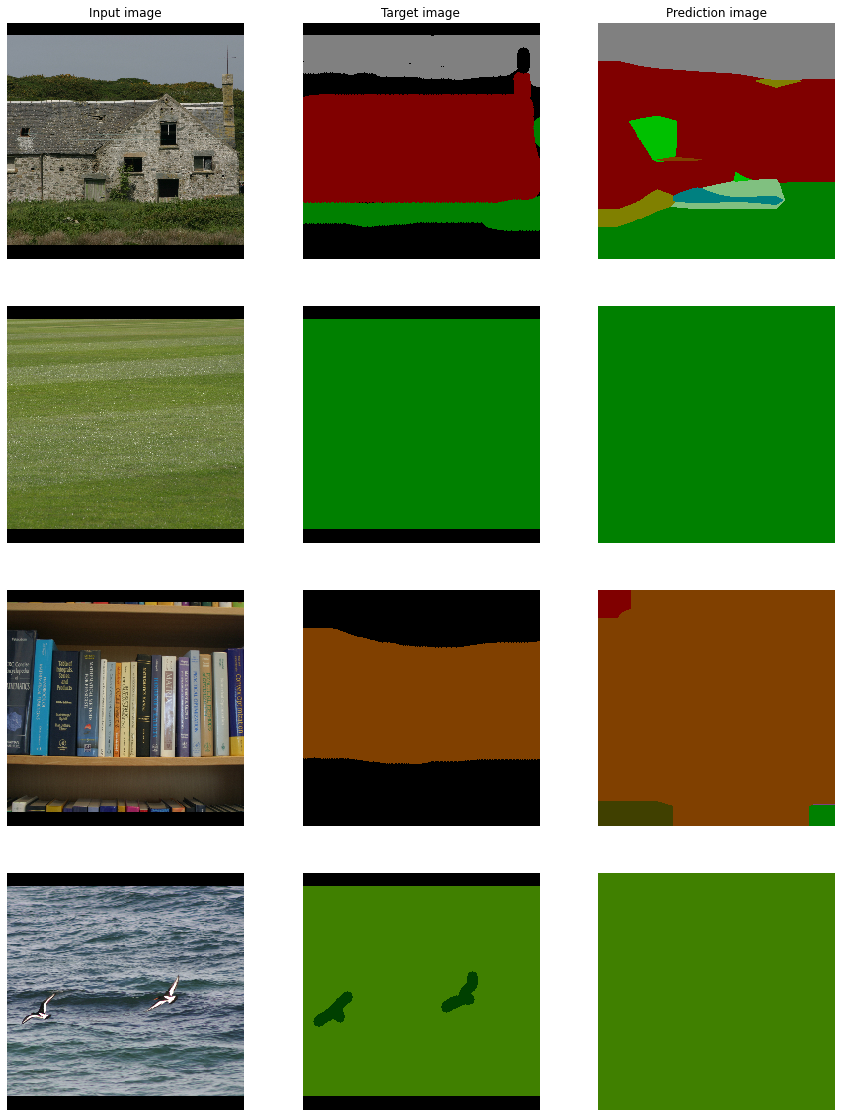

In [15]:
visualizer(model, test_data)

## Save the Model for Submission



In [ ]:
# os.makedirs('models', exist_ok=True)
# save_model(model, "segmentation_nn.model")
# checkSize(path = "./models/segmentation_nn.model")

In [ ]:
# from exercise_code.util.submit import submit_exercise

# submit_exercise('exercise10')


# Submission Goals

- Goal: Implement and train a convolutional neural network for Semantic Segmentation.
- Passing Criteria: Reach **Accuracy >= 64%** on __our__ test dataset. The submission system will show you your score after you submit.
